In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from nltk import corpus
from nltk.corpus import stopwords
#this is for punctuation 
import string
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
import pickle

In [2]:
df = pd.read_csv('/Users/mac/Desktop/DataScience/NLP/Spam-Ham-Classifier/spam.csv',encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

- There are 5572 sms

## 1. Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
#dropping the columns
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [7]:
df.sample(5)

,v1,v2
2802,spam,FreeMsg>FAV XMAS TONES!Reply REAL
2858,ham,Do you know why god created gap between your f...
163,spam,-PLS STOP bootydelious (32/F) is inviting you ...
1022,ham,We still on for tonight?
3174,spam,UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 a...


In [8]:
df.rename(columns={'v1':'Target','v2':'Text'},inplace=True)

In [9]:
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])

In [11]:
df.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
#checking missing values
df.isnull().sum()

Target    0
Text      0
dtype: int64

In [13]:
#checking for duplicates
df.duplicated().sum()

403

In [14]:
df = df.drop_duplicates(keep='first')

In [15]:
df.shape

(5169, 2)

## 2. EDA

In [16]:
(df['Target'].value_counts()/df.shape[0])*100

0    87.366996
1    12.633004
Name: Target, dtype: float64

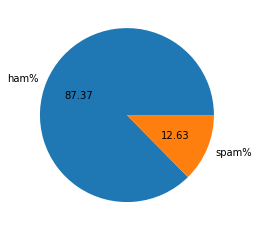

In [17]:
plt.pie((df['Target'].value_counts()/df.shape[0])*100,labels=['ham%','spam%'],autopct='%0.2f')
plt.show()

- Clearly this is a case of imbalanced data.

In [18]:
#nltk.download('punkt')

In [19]:
#numer of char in each sentence
df['Num_Chars'] = df['Text'].apply(len)

In [20]:
#fetch the number of words
df['Num_Words'] = df['Text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [21]:
#number of sentences
df['Num_Sentences'] = df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [22]:
df.head(3)

,Target,Text,Num_Chars,Num_Words,Num_Sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2


In [23]:
df.describe()

,Target,Num_Chars,Num_Words,Num_Sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455407,1.961308
std,0.332253,58.236293,13.322448,1.432583
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [24]:
ham = df[df['Target'] == 0]
ham.describe()

,Target,Num_Chars,Num_Words,Num_Sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123339,1.815545
std,0.0,56.358207,13.491315,1.364098
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [25]:
spam = df[df['Target'] == 1]
spam.describe()

,Target,Num_Chars,Num_Words,Num_Sentences
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.969372
std,0.0,30.137753,7.008418,1.488910
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


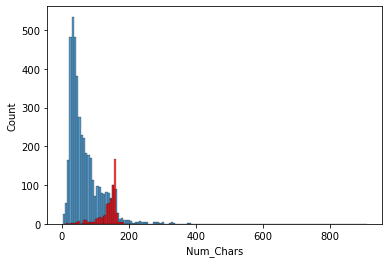

In [26]:
sns.histplot(ham['Num_Chars'])
sns.histplot(spam['Num_Chars'],color='red');

- We can see through this graph that spam messages uses more character than ham

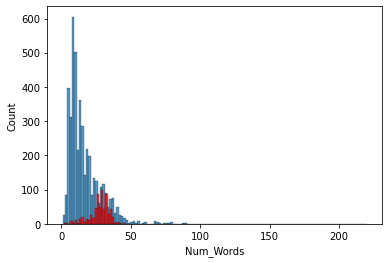

In [27]:
sns.histplot(ham['Num_Words'])
sns.histplot(spam['Num_Words'],color='red');

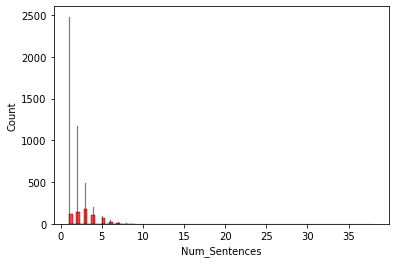

In [28]:
sns.histplot(ham['Num_Sentences'])
sns.histplot(spam['Num_Sentences'],color='red');

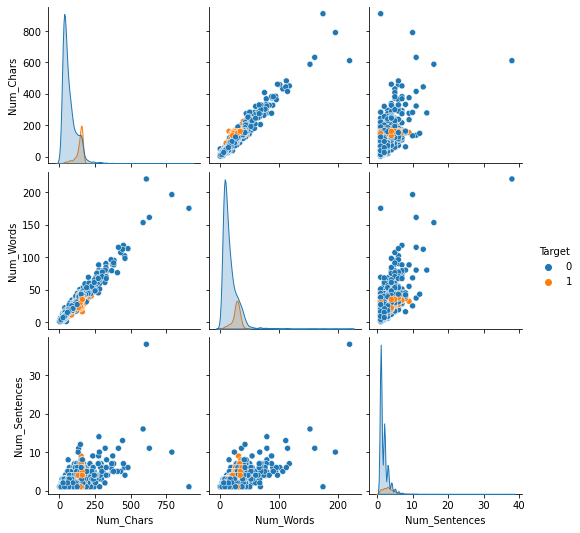

In [29]:
sns.pairplot(hue='Target',data=df);

- There are outliers.

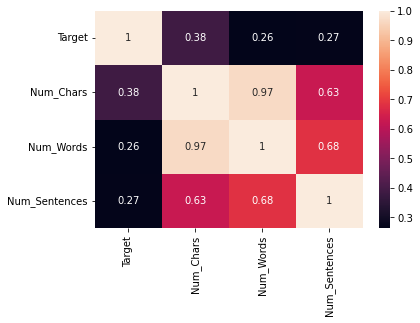

In [30]:
sns.heatmap(df.corr(),annot=True);

- Since there is high multi collinearity between feature. Therefore while building model we will only take one of the festures.

In [31]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    #removing special chars
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:] #clonning of list
    y.clear() 
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:] #clonning of list
    y.clear()
    
    ps = PorterStemmer()
    
    for i in text:
        y.append(ps.stem(i))
            
    
    return ' '.join(y)

In [32]:
transform_text('how are you Annie 3456778 %$^ ?')

'anni 3456778'

In [33]:
df['Transformed_Text'] = df['Text'].apply(transform_text)

In [34]:
df.head()

,Target,Text,Num_Chars,Num_Words,Num_Sentences,Transformed_Text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [35]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

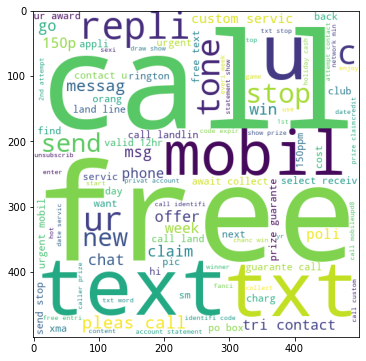

In [36]:
spam_wc = wc.generate(df[df['Target']==1]['Transformed_Text'].str.cat(sep=' '))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

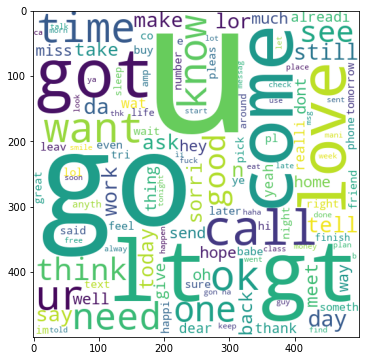

In [37]:
ham_wc = wc.generate(df[df['Target']==0]['Transformed_Text'].str.cat(sep=' '))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [38]:
spam_corpus = []
for msg in df[df['Target']==1]['Transformed_Text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


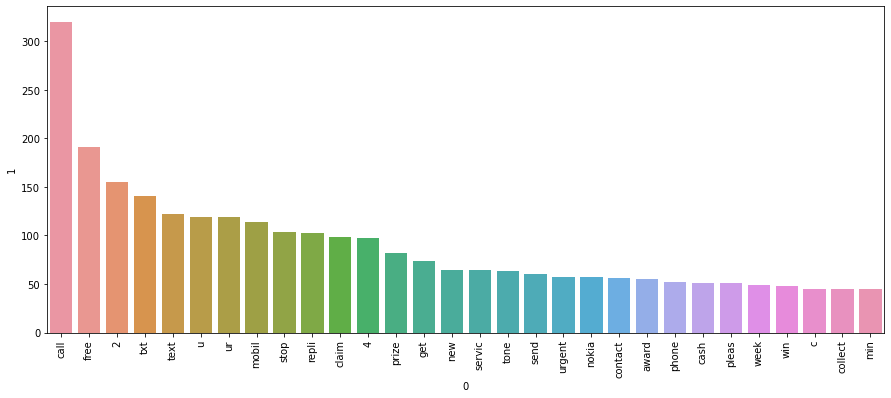

In [39]:
sp=pd.DataFrame(Counter(spam_corpus).most_common(30))
plt.figure(figsize=(15,6))
sns.barplot(sp[0],sp[1])
plt.xticks(rotation='vertical')
plt.show()

In [40]:
ham_corpus = []
for msg in df[df['Target']==0]['Transformed_Text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


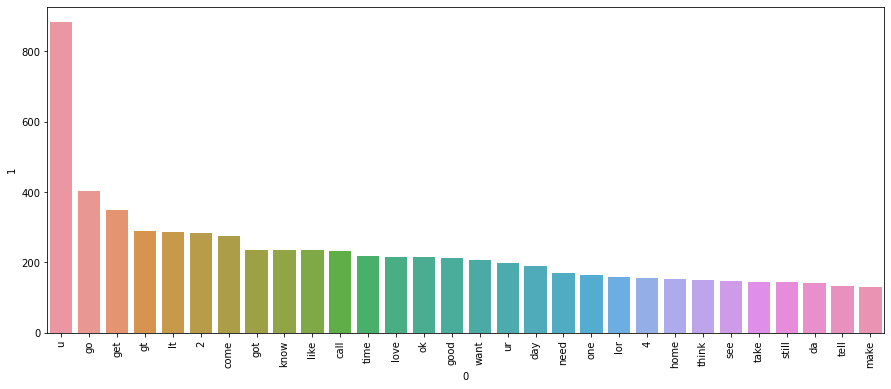

In [41]:
h=pd.DataFrame(Counter(ham_corpus).most_common(30))
plt.figure(figsize=(15,6))
sns.barplot(h[0],h[1])
plt.xticks(rotation='vertical')
plt.show()

## Model Building

In [42]:
cv = CountVectorizer()
X = cv.fit_transform(df['Transformed_Text']).toarray()

In [43]:
X.shape

(5169, 6708)

In [44]:
y = df['Target'].values

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [46]:
gng = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [47]:
gng.fit(X_train,y_train)
y_pred1 = gng.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred1))
print('Confusion Matrix:',confusion_matrix(y_test,y_pred1))
print('Precision Score:',precision_score(y_test,y_pred1))

Accuracy: 0.8800773694390716
Confusion Matrix: [[792 104]
 [ 20 118]]
Precision Score: 0.5315315315315315


In [48]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred2))
print('Confusion Matrix:',confusion_matrix(y_test,y_pred2))
print('Precision Score:',precision_score(y_test,y_pred2))

Accuracy: 0.9642166344294004
Confusion Matrix: [[871  25]
 [ 12 126]]
Precision Score: 0.8344370860927153


In [49]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred3))
print('Confusion Matrix:',confusion_matrix(y_test,y_pred3))
print('Precision Score:',precision_score(y_test,y_pred3))

Accuracy: 0.9700193423597679
Confusion Matrix: [[893   3]
 [ 28 110]]
Precision Score: 0.9734513274336283


- Since there is an imbalanced data hence precision matters here most.

##### Using tf-idf

In [104]:
tv = TfidfVectorizer()
X = tv.fit_transform(df['Transformed_Text']).toarray()

In [105]:
y = df['Target'].values

In [106]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [107]:
gng = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [108]:
gng.fit(X_train,y_train)
y_pred1 = gng.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred1))
print('Confusion Matrix:',confusion_matrix(y_test,y_pred1))
print('Precision Score:',precision_score(y_test,y_pred1))

Accuracy: 0.8762088974854932
Confusion Matrix: [[793 103]
 [ 25 113]]
Precision Score: 0.5231481481481481


In [109]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred2))
print('Confusion Matrix:',confusion_matrix(y_test,y_pred2))
print('Precision Score:',precision_score(y_test,y_pred2))

Accuracy: 0.9593810444874274
Confusion Matrix: [[896   0]
 [ 42  96]]
Precision Score: 1.0


In [56]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred3))
print('Confusion Matrix:',confusion_matrix(y_test,y_pred3))
print('Precision Score:',precision_score(y_test,y_pred3))

Accuracy: 0.9700193423597679
Confusion Matrix: [[893   3]
 [ 28 110]]
Precision Score: 0.9734513274336283


- choosen tf-idf and algo- Multinomial

In [57]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [58]:
clfs = {
    'SVC':svc,
    'KN':knc,
    'NB':mnb,
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [59]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [60]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9729206963249516, 0.9741379310344828)

In [61]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729206963249516
Precision -  0.9741379310344828
For  KN
Accuracy -  0.9003868471953579
Precision -  1.0
For  NB
Accuracy -  0.9593810444874274
Precision -  1.0
For  DT
Accuracy -  0.9361702127659575
Precision -  0.8461538461538461
For  LR
Accuracy -  0.9516441005802708
Precision -  0.94
For  RF
Accuracy -  0.971953578336557
Precision -  1.0
For  AdaBoost
Accuracy -  0.9613152804642167
Precision -  0.9454545454545454
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8625954198473282
For  ETC
Accuracy -  0.9729206963249516
Precision -  0.9824561403508771
For  GBDT
Accuracy -  0.9526112185686654
Precision -  0.9238095238095239
For  xgb
Accuracy -  0.9700193423597679
Precision -  0.9349593495934959


In [62]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [63]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.900387,1.000000
2,NB,0.959381,1.000000
5,RF,0.971954,1.000000
8,ETC,0.972921,0.982456
0,SVC,0.972921,0.974138
6,AdaBoost,0.961315,0.945455
4,LR,0.951644,0.940000
10,xgb,0.970019,0.934959
9,GBDT,0.952611,0.923810
7,BgC,0.958414,0.862595


In [64]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [65]:
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.900387
1,NB,Accuracy,0.959381
2,RF,Accuracy,0.971954
3,ETC,Accuracy,0.972921
4,SVC,Accuracy,0.972921
5,AdaBoost,Accuracy,0.961315
6,LR,Accuracy,0.951644
7,xgb,Accuracy,0.970019
8,GBDT,Accuracy,0.952611
9,BgC,Accuracy,0.958414


In [66]:
# model improve
# 1. Change the max_features parameter of TfIdf

In [67]:
tv = TfidfVectorizer(max_features=3000)
X = tv.fit_transform(df['Transformed_Text']).toarray()
y = df['Target'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [68]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [69]:
clfs = {
    'SVC':svc,
    'KN':knc,
    'NB':mnb,
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [70]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [71]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9758220502901354
Precision -  0.9747899159663865
For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB
Accuracy -  0.9709864603481625
Precision -  1.0
For  DT
Accuracy -  0.9303675048355899
Precision -  0.8367346938775511
For  LR
Accuracy -  0.9584139264990329
Precision -  0.9702970297029703
For  RF
Accuracy -  0.9758220502901354
Precision -  0.9829059829059829
For  AdaBoost
Accuracy -  0.960348162475822
Precision -  0.9292035398230089
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8682170542635659
For  ETC
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406
For  GBDT
Accuracy -  0.9468085106382979
Precision -  0.9191919191919192
For  xgb
Accuracy -  0.9671179883945842
Precision -  0.9333333333333333


In [74]:
performance_df1 = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft3000':accuracy_scores,'Precision_max_ft3000':precision_scores}).sort_values('Precision_max_ft3000',ascending=False)

In [75]:
performance_df1

,Algorithm,Accuracy_max_ft3000,Precision_max_ft3000
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.975822,0.982906
0,SVC,0.975822,0.974790
8,ETC,0.974855,0.974576
4,LR,0.958414,0.970297
10,xgb,0.967118,0.933333
6,AdaBoost,0.960348,0.929204
9,GBDT,0.946809,0.919192
7,BgC,0.958414,0.868217


In [83]:
performance_df = pd.merge(on='Algorithm',left=performance_df,right=performance_df1)

In [84]:
performance_df

,Algorithm,Accuracy,Precision,Accuracy_max_ft3000,Precision_max_ft3000
0,KN,0.900387,1.000000,0.905222,1.000000
1,NB,0.959381,1.000000,0.970986,1.000000
2,RF,0.971954,1.000000,0.975822,0.982906
3,ETC,0.972921,0.982456,0.974855,0.974576
4,SVC,0.972921,0.974138,0.975822,0.974790
5,AdaBoost,0.961315,0.945455,0.960348,0.929204
6,LR,0.951644,0.940000,0.958414,0.970297
7,xgb,0.970019,0.934959,0.967118,0.933333
8,GBDT,0.952611,0.923810,0.946809,0.919192
9,BgC,0.958414,0.862595,0.958414,0.868217


- The benefit we got is that our accuracy increased in somecases.
#### Voting Classifier

In [100]:
#taking the models that performed nicely
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()

vc = VotingClassifier(estimators = [('svm',svc),('rfc',rfc),('etc',etc),('mnb',mnb)],voting='soft')

In [101]:
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('rfc',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2)),
                             ('etc',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2)),
                             ('mnb', MultinomialNB())],
                 voting='soft')

In [102]:
y_pred = vc.predict(X_test)
print('Accuracy:',accuracy_score(y_test,y_pred))
print('Precision Score:',precision_score(y_test,y_pred))

Accuracy: 0.9796905222437138
Precision Score: 0.9915966386554622


- We are gonna apply Naive Bayes

In [111]:
pickle.dump(tv,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('sms_model.pkl','wb'))